# Import, Setup, and Classes

In [2]:
import tensorflow as tf
from tensorflow.train import Feature, Features, Example

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

import sys
from IPython.display import display 
from io import BytesIO
from collections import namedtuple

# # How to import custom module? 
# # https://tinyurl.com/y7dfv2l7
# sys.path.append('/content/gdrive/My Drive/melanoma/')
# from utils.fealib import TFRECParser

from PIL import Image
from skimage import io
import logging

from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
class TFRECParser:
    """Class to parse the TFRecord files that come with the original dataset.
    """
    __TFREC_DESCRIPTOR = {"image_name": tf.io.FixedLenFeature([], tf.string),
                          "image": tf.io.FixedLenFeature([], tf.string)}

    def __init__(self) -> None:
        self.__dataset = None # tf.data.TFRecordDataset

    @tf.autograph.experimental.do_not_convert
    def load(self, path_tfrec: str = 'tfrecords/train*.tfrec') -> None:
        def parser(serialized_example: Example) -> Example:
            example = tf.io.parse_single_example(serialized_example,
                                                 features=TFRECParser.__TFREC_DESCRIPTOR)
            return example
        self.__dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(path_tfrec))
        self.__dataset = self.__dataset.map(parser)

    def get_dataset(self) -> tf.data.Dataset:
        return self.__dataset

    def get_image_arr(self, image_name: str) -> np.ndarray:
        record_dataset = self.__dataset.filter(lambda example: tf.equal(example["image_name"], image_name))
        example = next(iter(record_dataset))
        arr = tf.image.decode_jpeg(example['image'], channels=3).numpy()
        return arr

    def get_image(self, image_name: str) -> Image:
        return Image.fromarray(self.get_image_arr(image_name))

    def plot_image(self, image_name: str, figsize: list = [5, 5]) -> Image:
        img_arr = self.get_image_arr(image_name)
        img = Image.fromarray(img_arr)

        # prep title
        title = "{}, {}x{}, {:.2f}MB".format(image_name,
                                             img.size[0],
                                             img.size[1],
                                             sys.getsizeof(img_arr)/1024/1024)

        # render plot
        plt.figure(figsize=figsize)
        io.imshow(img_arr)
        plt.title(title)
        plt.show()

class Logger:
    """Class to provide basic functions for producing log files.
    """
    __loggers = {}
    __path = 'log.txt'

    @staticmethod
    def set_log_file_path(path: str) -> None:
        Logger.__path = path

    @staticmethod
    def get_logger(name: str) -> logging:
        # return instance if already exist
        if Logger.__loggers.get(name):
            return Logger.__loggers.get(name)

        # create a new isstance
        logger = logging.getLogger(name)
        logger.setLevel(logging.INFO)

        # build handler
        f_handler = logging.FileHandler(Logger.__path)
        formatter = logging.Formatter("[%(asctime)s] %(message)s",
                                    "%Y-%m-%d %H:%M:%S")
        f_handler.setFormatter(formatter)
        logger.addHandler(f_handler)

        # store logger to static arr
        Logger.__loggers[name] = logger

        return logger

# Exploratory Data **Analysis**


## Tfrecord Files

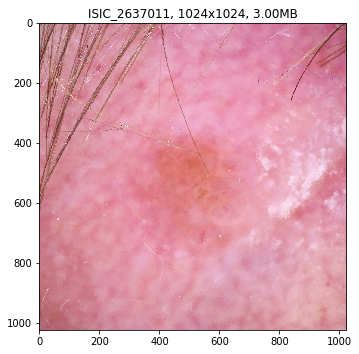

In [75]:
# initialize parser & render a smaple image
parser = TFRECParser()
parser.load('/content/gdrive/My Drive/Kaggle/melanoma/tfrecords/train*.tfrec')
parser.plot_image('ISIC_2637011')

## JPEG Compression

Original:


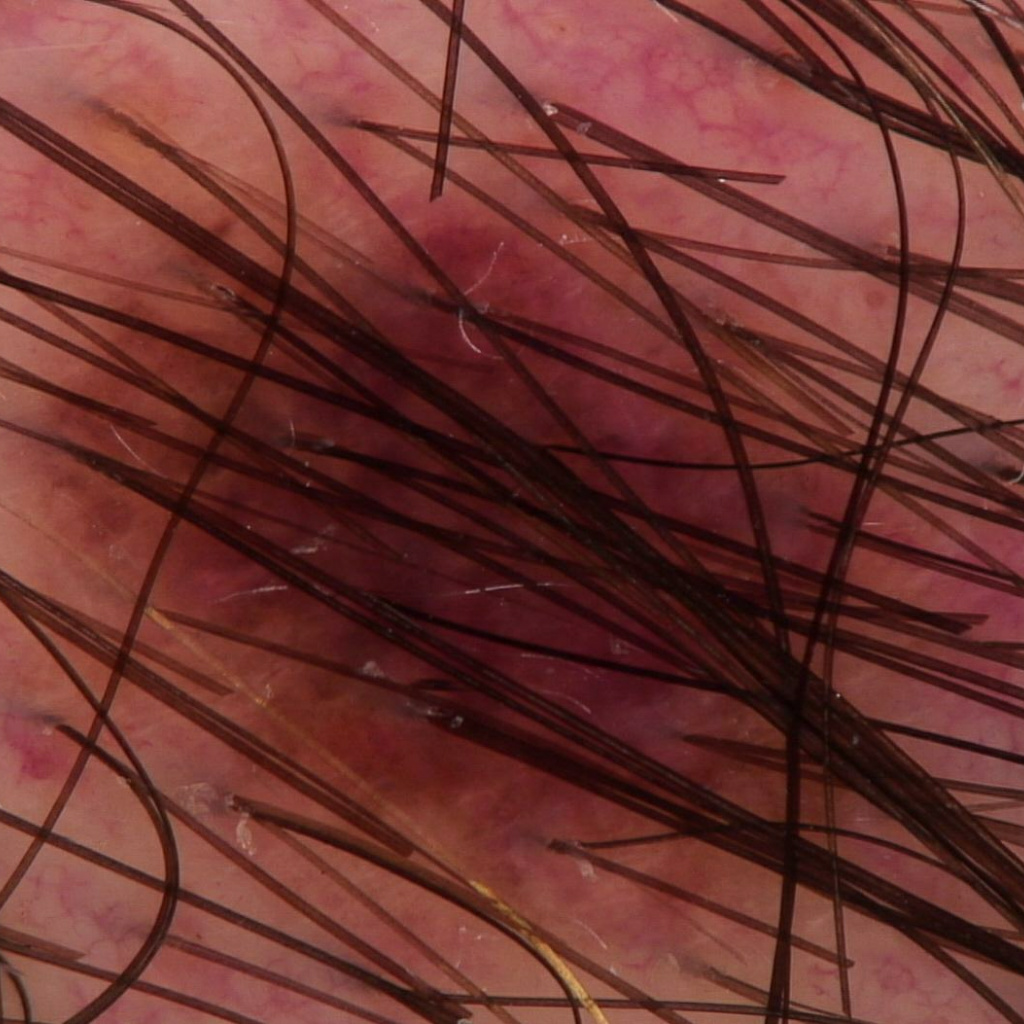



Compressed (JPEG 60):


NameError: ignored

In [7]:
print('Original:')
img = parser.get_image('ISIC_0068279')
display(img)

print('\n\nCompressed (JPEG 60):')
img.save('/content/gdrive/My Drive/melanoma/temp/test60.jpg', 'JPEG', quality=60)
print ("{:.2f} MB".format(os.stat('/content/gdrive/My Drive/melanoma/temp/test60.jpg').st_size/1204/1024))
img_compress = Image.open('/content/gdrive/My Drive/melanoma/temp/test60.jpg')
display(img_compress)

print('\n\nCompressed (JPEG 100):')
img.save('/content/gdrive/My Drive/melanoma/temp/test100.jpg', 'JPEG', quality=100)
print ("{:.2f} MB".format(os.stat('/content/gdrive/My Drive/melanoma/temp/test100.jpg').st_size/1204/1024))
img_compress = Image.open('/content/gdrive/My Drive/melanoma/temp/test100.jpg')
display(img_compress)

In [74]:
# ImageDataGenerator transformation demo
JPEG_PATH = '/content/gdrive/My Drive/Kaggle/melanoma/jpeg_compressed/q_60/train/'

img = Image.open(JPEG_PATH + 'ISIC_0052212.jpg')
img_arr = np.array(img)

# transform params
# https://tinyurl.com/yazmy6of
imggen = ImageDataGenerator(fill_mode='constant')
img_arr_t = imggen.apply_transform(x=img_arr, 
                                   transform_parameters={'theta':45,
                                                         'flip_horizontal': True,
                                                         'flip_vertical': True,
                                                         'zx': 0.8,
                                                         'zy': 0.8}).astype(np.uint8)

fig, axes = plt.subplots(1, 2, figsize=(10, 15))
axes[0].imshow(img_arr)
axes[1].imshow(img_arr_t)
axes[0].set_title('Original')
axes[1].set_title('Transformed')

plt.show()
pass

OSError: ignored

In [ ]:
# codes to compress JPEGs
# boolean to avoid accidental compression
EXE_COMPRESSION = False
if EXE_COMPRESSION:
    dataset = parser.get_dataset()
    for item in dataset:
        name = tf.compat.as_text(item['image_name'].numpy()) + '.jpg'
        img_arr = tf.image.decode_jpeg(item['image'], channels=3).numpy()

        img = Image.fromarray(img_arr)
        img.save('/content/gdrive/My Drive/Kaggle/melanoma/jpeg_compressed/q_100/train/' + name, 'JPEG', quality=100)

# Model Building - Barebone CNN

In [73]:
from typing import Generator, List, Dict

class MelDSManager:
    """Data manager for Kaggle's SIIM-ISIC Melanoma Classification competition.
    """
    TRAIN_CSV_DEFAULT_PATH = '/content/gdrive/My Drive/Kaggle/melanoma/csv/train.csv'
    TEST_CSV_DEFAULT_PATH = '/content/gdrive/My Drive/Kaggle/melanoma/csv/test.csv'

    
    def __init__(self) -> None:
        self.__df_train = None # pd DataFrame
        self.__df_test = None # pd DataFrame
        self.__index = 0 # index pointing to first row of the next batch
        self.__batch_size = 10 

    @property
    def train_size(self) -> int:
        if self.__df_train is None:
            return 0
        return self.__df_train.shape[0]

    @property
    def batch_size(self) -> int:
        return self.__batch_size

    @batch_size.setter
    def batch_size(self, batch_size: int) -> None:
        """Size of the mini-batch. Set to 0 for full-batch.
        """
        if batch_size == 0:
            if self.__df_train is not None:
                batch_size = self.__df_train.shape[0]
            else:
                batch_size = 1

        self.__batch_size = batch_size

    def load_csv(self, train_csv_path: str = TRAIN_CSV_DEFAULT_PATH,
                 test_csv_path: str = TEST_CSV_DEFAULT_PATH) -> List[pd.DataFrame]:
        """Method to load training and test csv files.
        Returns:
            list: [0] DF for training. [1] DF for testing.
        """
        self.__df_train = pd.read_csv(train_csv_path)
        self.__df_test = pd.read_csv(test_csv_path)

    def shuffle_train(self) -> None:
        """Shuffle the training dataset. 
        
        When calling get_train_batch_generator(), examples will always be read in 
        the order of the rows as they are stored in csv. Without shuffling, you 
        would always end up with the same cases in each of the batches.
        """
        self.__df_train = self.__df_train.sample(frac=1).reset_index(drop=True)
                                  
    def get_train_batch_generator(self, 
                                  loop: int = 1, 
                                  batch_size: int = -1,
                                  max_batch_num: int = -1,
                                  positive_case_pct: float = -1) -> Generator[dict, None, None]:
        """
        Args:
            loop (int): Param to set how many loops returned generator will go 
                through the training dataset.

            batch_size (int): Size of the mini-batch; set 0 for the full batch.
            
            max_batch_num (int): Maximum # of batches the returned generator will 
                produce. Iteration will end if max_batch_num is reached before the 
                end of the loop (and vice versa). Set to -1 to remove the max limit.
            
            positive_case_pct (float): Force a percentage of the examples included 
                in the batch to be positive cases (i.e. target=1). Set to -1 to 
                remove the restriction. 
        Returns:
            Generator[dict, None, None]: A dictionary of np.ndarray. Generator will 
                continue until end of looping.

                'urls':     Array of image URLs; image_name column in csv, prefixed 
                            with the path to the image director.
                'labels':   Array of labels; target column in csv.
                'others':   Array of pd.Series that contains the rest of the columns 
                            in CSV.

                Note that the last batch will loop back to the beginning of the 
                training data set if the training size is not an exact multiple of 
                the batch size.
        """
        if batch_size > -1:
            self.batch_size = batch_size

        if positive_case_pct == -1:
            while (loop > 0):
                if max_batch_num == 0:
                    break;

                image_arr = np.zeros(self.batch_size)
                label_arr = np.zeros(self.batch_size)
                other_arr = np.zeros(self.batch_size)

                # extract the right segment from df
                index_end = self.__index + self.batch_size
                batch_df = None 
                if index_end < self.train_size:
                    batch_df = self.__df_train.iloc[self.__index: index_end, :]
                    self.__index = index_end
                else:
                    batch_df1 = self.__df_train.iloc[self.__index: index_end, :]
                    index_end = self.batch_size - (self.train_size - self.__index)
                    batch_df2 = self.__df_train.iloc[: index_end, :]
                    
                    batch_df = pd.concat([batch_df1, batch_df2], ignore_index=True)
                    self.__index = index_end
                    loop -= 1
                
                if max_batch_num > 0:
                    max_batch_num -= 1
                
                yield self.__parse_csv_df(batch_df)
        else:
            while (loop > 0):
                if max_batch_num == 0:
                    break;

                # split the +ve and -ve cases
                df_negative = self.__df_train[:, self.__df_train['target'] == 0]
                df_positive = self.__df_train[:, self.__df_train['target'] == 1]

                # initialize data arr
                image_arr = np.zeros(self.batch_size)
                label_arr = np.zeros(self.batch_size)
                other_arr = np.zeros(self.batch_size)

                # extract the right segment from df
                index_end = self.__index + self.batch_size
                batch_df = None 
                if index_end < self.train_size:
                    batch_df = self.__df_train.iloc[self.__index: index_end, :]
                    self.__index = index_end
                else:
                    batch_df1 = self.__df_train.iloc[self.__index: index_end, :]
                    index_end = self.batch_size - (self.train_size - self.__index)
                    batch_df2 = self.__df_train.iloc[: index_end, :]
                    
                    batch_df = pd.concat([batch_df1, batch_df2], ignore_index=True)
                    self.__index = index_end
                    loop -= 1
                
                if max_batch_num > 0:
                    max_batch_num -= 1
                
                yield self.__parse_csv_df(batch_df)

    def __parse_csv_df(sef, df: pd.DataFrame) -> dict:
        """Method to parse the df created out of the csv.
        Returns: 
            dict: A dictionary of np.ndarray. Generator will continue until end of looping.

                'urls':     Array of image URLs; image_name column in csv, prefixed 
                            with the path to the image director.
                'labels':   Array of labels; target column in csv.
                'others':   Array of pd.Series that contains the rest of the columns 
                            in CSV.
        """

        urls = df.loc[:, 'image_name'].to_numpy()
        labels = df.loc[:, 'target'].to_numpy()
        others = df.loc[:, 
                        (df.columns != 'image_name') & 
                        (df.columns != 'target')].to_numpy()

        return {'urls': urls, 'labels': labels, 'others': others}

    def get_train_batch_generator(inputPath, batch_size, lb, mode="train", aug=None):

manager = MelDSManager()
manager.load_csv()

df = pd.DataFrame(list(range(0, 11)))

manager.batch_size = 3
gen = manager.get_train_batch_generator(loop=1, max_batch_num=5)

i = 0
for v in gen:
    display(v)
    print('---')
    i+= 1

{'data': array([['IP_7279968', 'male', 45.0, 'head/neck', 'unknown', 'benign'],
        ['IP_3075186', 'female', 45.0, 'upper extremity', 'unknown',
         'benign'],
        ['IP_2842074', 'female', 50.0, 'lower extremity', 'nevus',
         'benign']], dtype=object),
 'labels': array([0, 0, 0]),
 'urls': array(['ISIC_2637011', 'ISIC_0015719', 'ISIC_0052212'], dtype=object)}

---


{'data': array([['IP_6890425', 'female', 45.0, 'head/neck', 'unknown', 'benign'],
        ['IP_8723313', 'female', 55.0, 'upper extremity', 'unknown',
         'benign'],
        ['IP_2950485', 'female', 40.0, 'lower extremity', 'unknown',
         'benign']], dtype=object),
 'labels': array([0, 0, 0]),
 'urls': array(['ISIC_0068279', 'ISIC_0074268', 'ISIC_0074311'], dtype=object)}

---


{'data': array([['IP_4698288', 'male', 25.0, 'lower extremity', 'unknown',
         'benign'],
        ['IP_6017204', 'female', 35.0, 'torso', 'unknown', 'benign'],
        ['IP_7622888', 'male', 30.0, 'torso', 'unknown', 'benign']],
       dtype=object),
 'labels': array([0, 0, 0]),
 'urls': array(['ISIC_0074542', 'ISIC_0075663', 'ISIC_0075914'], dtype=object)}

---


{'data': array([['IP_5075533', 'female', 50.0, 'lower extremity', 'unknown',
         'benign'],
        ['IP_9802602', 'male', 55.0, 'upper extremity', 'unknown',
         'benign'],
        ['IP_2318163', 'male', 75.0, 'upper extremity', 'unknown',
         'benign']], dtype=object),
 'labels': array([0, 0, 0]),
 'urls': array(['ISIC_0076262', 'ISIC_0076545', 'ISIC_0076742'], dtype=object)}

---


{'data': array([['IP_2235340', 'female', 55.0, 'torso', 'nevus', 'benign'],
        ['IP_3691360', 'female', 40.0, 'torso', 'unknown', 'benign'],
        ['IP_1109756', 'male', 70.0, 'torso', 'unknown', 'benign']],
       dtype=object),
 'labels': array([0, 0, 0]),
 'urls': array(['ISIC_0076995', 'ISIC_0077472', 'ISIC_0077735'], dtype=object)}

---


In [9]:
# data config
TRAIN_CSV_FILE = '/content/gdrive/My Drive/Kaggle/melanoma/csv/train.csv'
TRAIN_JPEG_PATH = '/content/gdrive/My Drive/Kaggle/melanoma/jpeg_compressed/q_60/train/'
IMG_W = 1024
IMG_H = 1024

# model configs
CONFIGS = namedtuple('CONFIGS_CNN_BAREBONE', ())
CONFIGS.EPOCHS = 2
CONFIGS.BATCH_SIZE = 1

# train_csv = pd.read_csv(TRAIN_CSV_FILE)
# train_csv.head()

img1 = Image.open(TRAIN_JPEG_PATH + 'ISIC_0052212.jpg')
img2 = Image.open(TRAIN_JPEG_PATH + 'ISIC_0075914.jpg')

# construct training/testing dataset
img1_arr = np.array(img1).reshape(IMG_W, IMG_H, 3)
img2_arr = np.array(img2).reshape(IMG_W, IMG_H, 3)
X_train = np.array([img1_arr, img2_arr])
Y_train = [0, 1]

# one-hot encoding
Y_train = to_categorical(Y_train)

# build cnn barabone
model_cbb = Sequential()
# 1024x1024x3 => (3x3x3)x64 => 1022x1022x64
model_cbb.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(1024, 1024, 3)))
# 1022x1022x64 => (3x3x32)x32 => 1020x1020x32
model_cbb.add(Conv2D(32, kernel_size=3, activation='relu'))
# 1020x1020x32 => 33,554,432
model_cbb.add(Flatten())
# 33,554,432 => 10
model_cbb.add(Dense(2, activation='softmax'))

# compile model; use accuracy to measure model performance
# Note: 
#   - Optimizer is used to accelerate gradient descent.
#   - Adam accelerates GD using momentum and RMSpeop.
model_cbb.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, 
                         zoom_range=0.15,
                         width_shift_range=0.2, 
                         height_shift_range=0.2, 
                         shear_range=0.15,
                         horizontal_flip=True, 
                         fill_mode="constant")

# train with generator network
# steps_per_epoch: Total # of steps (images) to yield from generator before 
#                  declaring one epoch finished and starting the next epoch. 
#                  https://tinyurl.com/y8pcddn2
model_cbb.fit(aug.flow(X_train, 
                       Y_train, 
                       batch_size=CONFIGS.BATCH_SIZE),
              validation_data=(X_train, 
                               Y_train), 
              steps_per_epoch=len(X_train),
              epochs=CONFIGS.EPOCHS)

# train without generator
# model_cbb.fit(X_train, 
#               Y_train, 
#               validation_data=(X_train, Y_train), 
#               epochs=CONFIGS.EPOCHS)

# predict
preds = model_cbb.predict(X_train)
print(classification_report(Y_train, preds))

Epoch 1/2
2/2 [==============================] - 7s 4s/step - loss: 167958.4219 - accuracy: 0.0000e+00 - val_loss: 93102.4609 - val_accuracy: 0.5000
Epoch 2/2
2/2 [==============================] - 6s 3s/step - loss: 55211.5703 - accuracy: 0.5000 - val_loss: 4414.5376 - val_accuracy: 0.5000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2
 samples avg       0.50      0.50      0.50         2



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
